In [28]:
%load_ext autoreload
%autoreload 2

# Imports
import Functions as Funcs
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Running Lambert Scanner for Single Initial SC Position

In [ ]:
# Defining Spacecraft parking orbit elements
sc_elements = {
    'a': 3 * u.au,
    'e': 0,
    'i': 45 * u.deg,
    'Omega': 0 * u.deg,
    'omega': 0 * u.deg,
    'nu': 0 * u.deg
}

sim_params = {
    't_burn': -1200 * u.day,
    'nu_burn': 180 * u.deg, # S/C at aphelion/perihelion etc
    'max_flight_time': 1000 * u.day,
    'max_distance': 20 * u.au,
    'a_electric': 0 * u.mm / u.s**2,  # mm/s^2 (Low thrust)
    
    # This vector is what you would iterate on to minimize miss distance
    'dv_chemical_vector': np.array([-1, 0, 5.5]) * u.km / u.s # Defined in the spacecraft orbital frame
}

mission = Funcs.InterceptorMission(iso_elements=Funcs.characteristic_heliocentric_elements,
                                  sc_elements=sc_elements,
                                  sim_params=sim_params)

anim1, anim2 = mission.solve_intercept_lambert_scanner(animate=False, steps=1)

100%|██████████| 999/999 [00:17<00:00, 57.65it/s] 


=== Lambert Scan Results ===
Optimal Chemical Delta-V Vector Required at Burn: [-0.54713056 -1.11577285  1.39430446] km/s
Optimal Chemical Delta-V Magnitude Required at Burn: 1.868 km/s
Minimum Distance at Intercept: 0.000 AU, 13543 km
Time of Minimum Distance: -92.89 d after ISO Perihelion


Time of Minimum Relative Velocity (from delta V below 15 km/s): 955.96 d days since ISO perihelion
Minimum Relative Velocity (from delta V below 15 km/s): 23.34 km/s


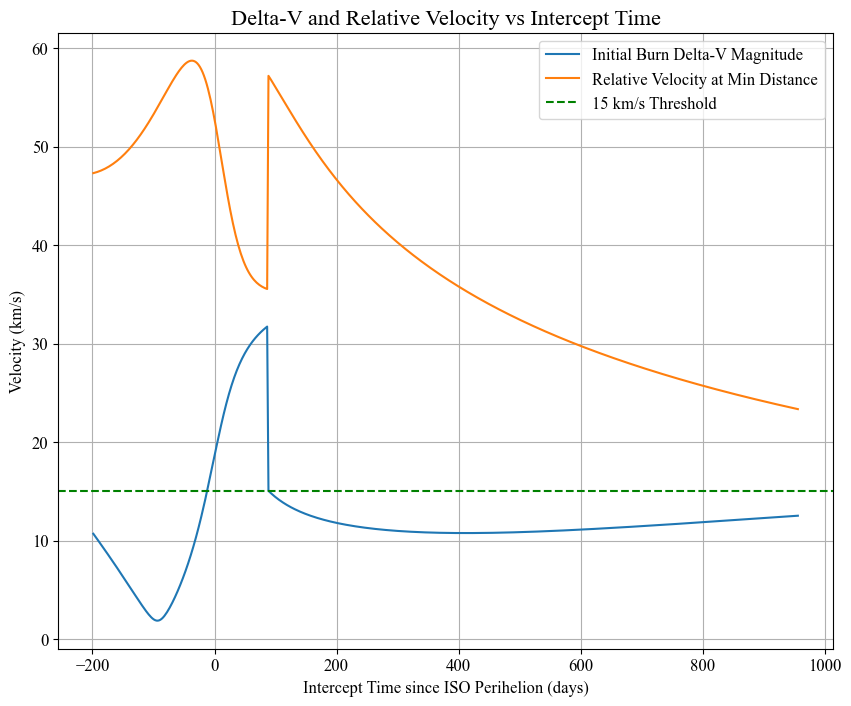

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

after_perihelion_index = np.where(mission.scanner_times_array.to(u.day).value >= -200)

delta_v_mags = np.linalg.norm(mission.dv_history_array, axis=1).value
relative_velocity_mags = mission.rel_v_of_min_distance_history_array.value

below_v_threshold_index = np.where(delta_v_mags <= 15)

min_rel_velocity_index = np.argmin(relative_velocity_mags[below_v_threshold_index])
min_rel_velocity = relative_velocity_mags[min_rel_velocity_index]
time_min_rel_velocity = mission.scanner_times_array.to(u.day)[below_v_threshold_index][min_rel_velocity_index]
print(f"Time of Minimum Relative Velocity (from delta V below 15 km/s): {time_min_rel_velocity:.2f} days since ISO perihelion")
print(f"Minimum Relative Velocity (from delta V below 15 km/s): {min_rel_velocity:.2f} km/s")

ax.plot(mission.scanner_times_array.to(u.day)[after_perihelion_index].value, delta_v_mags[after_perihelion_index], label='Initial Burn Delta-V Magnitude')
ax.plot(mission.scanner_times_array.to(u.day)[after_perihelion_index].value, relative_velocity_mags[after_perihelion_index], label='Relative Velocity at Min Distance')
# ax.axhline(y=np.min(relative_velocity_mags), color='r', linestyle='--', label='Minimum Relative Velocity')
ax.axhline(y=15, color='g', linestyle='--', label='15 km/s Threshold')

ax.set_xlabel('Intercept Time since ISO Perihelion (days)')
ax.set_ylabel('Velocity (km/s)')
ax.set_title('Delta-V and Relative Velocity vs Intercept Time')

ax.grid(True)

ax.legend(fontsize=12)

plt.show()

## Choosing 100 true anomalies for initial spacecraft burn and 100 detection times for ISO

In [43]:
nu_burns = np.linspace(0, 360, 100) * u.deg

# Defining vector of time of burns with respect to ISO perihelion
t_burns = np.array([40, -90, -200, -400, -700, -1200]) * u.day

minimum_rel_velocities = []
time_minimum_rel_velocities = []
delta_v_at_minimum_rel_velocities = []

for t_burn in t_burns:
    constant_t_burn_rel_velocities = []
    constant_t_burn_times = []
    constant_t_burn_delta_vs = []

    for i in tqdm(range(len(nu_burns)), desc=f"Processing t_burn = {t_burn}"):
        sim_params = {
            't_burn': t_burn,
            'nu_burn': nu_burns[i], # S/C at aphelion/perihelion etc
            'max_flight_time': 1000 * u.day,
            'max_distance': 20 * u.au,
            'a_electric': 0 * u.mm / u.s**2,  # mm/s^2 (Low thrust)
            
            # This vector is what you would iterate on to minimize miss distance
            'dv_chemical_vector': np.array([-1, 0, 5.5]) * u.km / u.s # Defined in the spacecraft orbital frame
        }

        mission = Funcs.InterceptorMission(iso_elements=Funcs.characteristic_heliocentric_elements,
                                        sc_elements=sc_elements,
                                        sim_params=sim_params)
        anim1, anim2 = mission.solve_intercept_lambert_scanner(animate=False, steps=10, verbose=False)

        delta_v_mags = np.linalg.norm(mission.dv_history_array, axis=1).value
        relative_velocity_mags = mission.rel_v_of_min_distance_history_array.value

        below_v_threshold_index = np.where(delta_v_mags <= 15)

        if len(below_v_threshold_index[0]) == 0:
            constant_t_burn_rel_velocities.append(np.nan)
            constant_t_burn_times.append(np.nan)
            constant_t_burn_delta_vs.append(np.nan)
            continue

        min_rel_velocity_index = np.argmin(relative_velocity_mags[below_v_threshold_index])
        min_rel_velocity = relative_velocity_mags[below_v_threshold_index][min_rel_velocity_index]
        time_min_rel_velocity = mission.scanner_times_array.to(u.day)[below_v_threshold_index][min_rel_velocity_index]
        delta_v_min_rel_velocity = delta_v_mags[below_v_threshold_index][min_rel_velocity_index]

        constant_t_burn_rel_velocities.append(min_rel_velocity)
        constant_t_burn_times.append(time_min_rel_velocity)
        constant_t_burn_delta_vs.append(delta_v_min_rel_velocity)

    minimum_rel_velocities.append(constant_t_burn_rel_velocities)
    time_minimum_rel_velocities.append(constant_t_burn_times)
    delta_v_at_minimum_rel_velocities.append(constant_t_burn_delta_vs)

Processing t_burn = 40.0 d:   0%|          | 0/100 [00:00<?, ?it/s]

Processing t_burn = -1200.0 d: 100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


In [ ]:
# import csv

# with open('lambert_scanner_results.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['t_burn (days)', 'nu_burn (degrees)', 'Minimum Relative Velocity (km/s)', 'Time at Minimum Relative Velocity (days)', 'Delta-V at Minimum Relative Velocity (km/s)'])
    
#     for t_burn_index, t_burn in enumerate(t_burns):
#         for nu_burn_index, nu_burn in enumerate(nu_burns):
#             min_rel_vel = minimum_rel_velocities[t_burn_index][nu_burn_index]
#             time_min_rel_vel = time_minimum_rel_velocities[t_burn_index][nu_burn_index]
#             delta_v_min_rel_vel = delta_v_at_minimum_rel_velocities[t_burn_index][nu_burn_index]
#             writer.writerow([t_burn.to(u.day).value, nu_burn.to(u.deg).value, min_rel_vel, time_min_rel_vel.to(u.day).value if isinstance(time_min_rel_vel, u.Quantity) else time_min_rel_vel, delta_v_min_rel_vel])

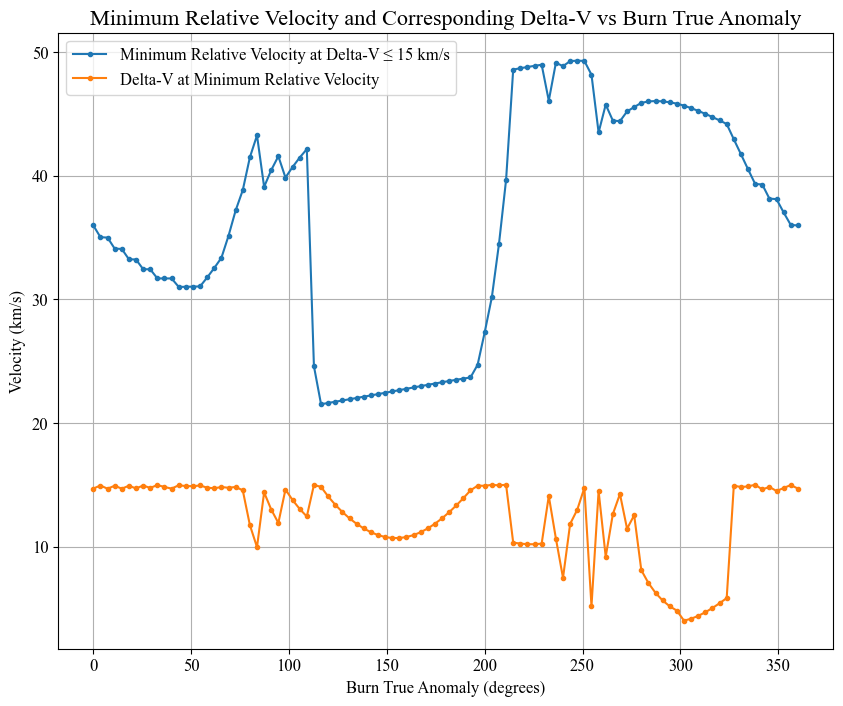

In [47]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.plot(nu_burns.to(u.deg).value, minimum_rel_velocities[-1], label='Minimum Relative Velocity at Delta-V ≤ 15 km/s', marker='.')
ax.plot(nu_burns.to(u.deg).value, delta_v_at_minimum_rel_velocities[-1], label='Delta-V at Minimum Relative Velocity', marker='.')
ax.set_xlabel('Burn True Anomaly (degrees)')
ax.set_ylabel('Velocity (km/s)')
ax.set_title('Minimum Relative Velocity and Corresponding Delta-V vs Burn True Anomaly')
ax.legend(fontsize=12)
ax.grid(True)

plt.show()

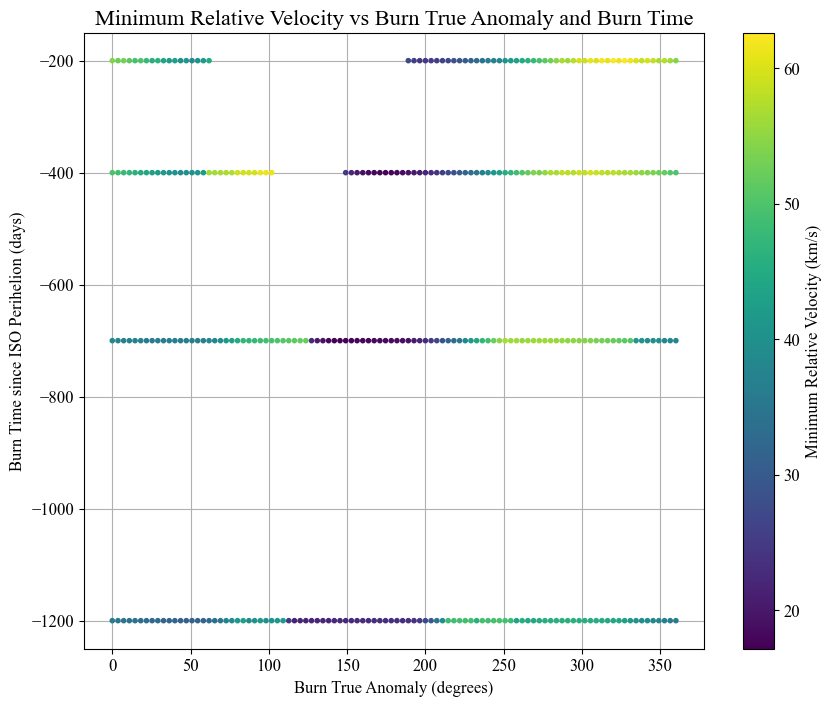

In [71]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

X, Y = np.meshgrid(nu_burns.to(u.deg).value, t_burns.to(u.day).value)
Z = np.array(minimum_rel_velocities)

sc = ax.scatter(X, Y, marker='.', c=Z, cmap='viridis', zorder=3)
# sc = ax.imshow(Z, extent=(0, 360, np.amin(t_burns).to(u.day).value, np.amax(t_burns).to(u.day).value), cmap='viridis', zorder=2, aspect='auto')
plt.colorbar(sc, label='Minimum Relative Velocity (km/s)')
ax.set_xlabel('Burn True Anomaly (degrees)')
ax.set_ylabel('Burn Time since ISO Perihelion (days)')
ax.set_title('Minimum Relative Velocity vs Burn True Anomaly and Burn Time')
ax.grid(True)
plt.show()

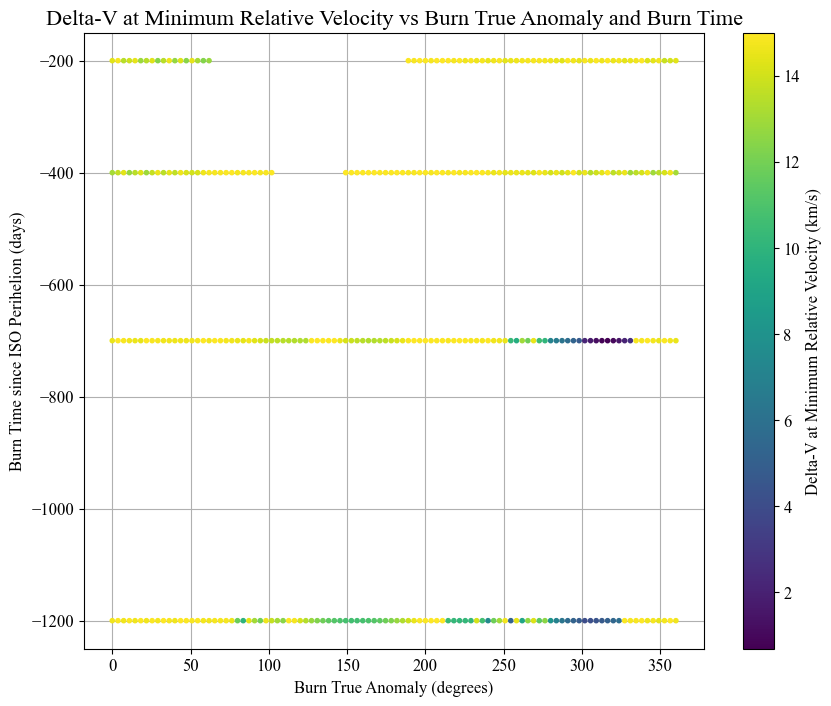

In [53]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

X, Y = np.meshgrid(nu_burns.to(u.deg).value, t_burns.to(u.day).value)
Z = np.array(delta_v_at_minimum_rel_velocities)

sc = ax.scatter(X, Y, marker='.', c=Z, cmap='viridis', zorder=2)
plt.colorbar(sc, label='Delta-V at Minimum Relative Velocity (km/s)')
ax.set_xlabel('Burn True Anomaly (degrees)')
ax.set_ylabel('Burn Time since ISO Perihelion (days)')
ax.set_title('Delta-V at Minimum Relative Velocity vs Burn True Anomaly and Burn Time')
ax.grid(True)
plt.show()

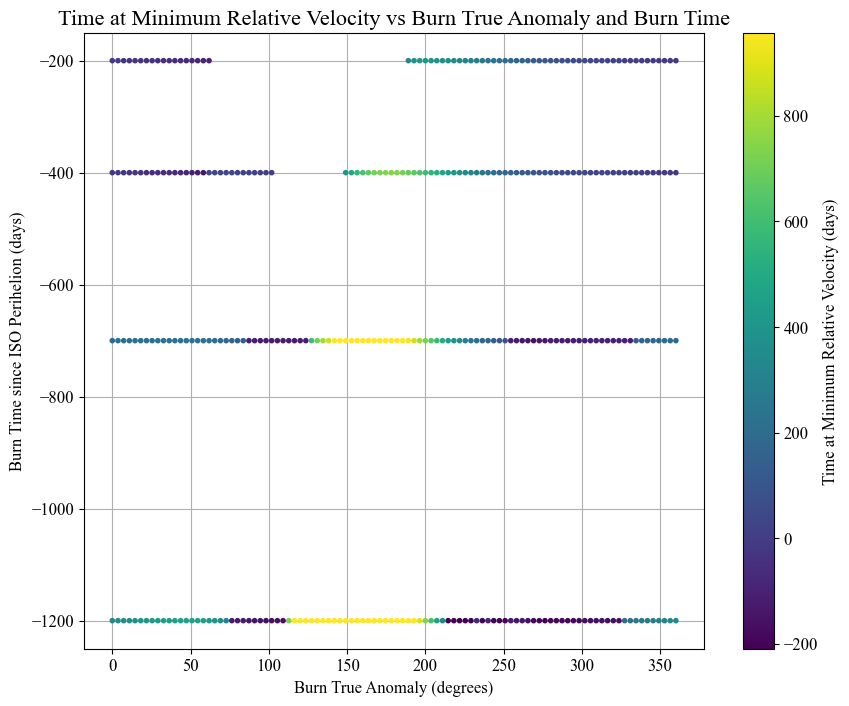

In [61]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

X, Y = np.meshgrid(nu_burns.to(u.deg).value, t_burns.to(u.day).value)

Z = []
for time_minimum_rel_velocities_row in time_minimum_rel_velocities:
    row = []
    for val in time_minimum_rel_velocities_row:
        if isinstance(val, float) and np.isnan(val):
            row.append(np.nan)
            continue
        val_days = val.to(u.day).value
        row.append(val_days)
    Z.append(row)

Z = np.array(Z)

sc = ax.scatter(X, Y, marker='.', c=Z, cmap='viridis', zorder=2)
plt.colorbar(sc, label='Time at Minimum Relative Velocity (days)')
ax.set_xlabel('Burn True Anomaly (degrees)')
ax.set_ylabel('Burn Time since ISO Perihelion (days)')
ax.set_title('Time at Minimum Relative Velocity vs Burn True Anomaly and Burn Time')
ax.grid(True)
plt.show()